In [1]:
import os.path

import episcanpy as epi
import scanpy as sc
import numpy as np
import anndata as ad
import pandas as pd
from scipy.sparse import issparse, csr_matrix, hstack
import tempfile
import requests
import warnings

%load_ext autoreload
%autoreload 2

import utils

### File Paths

In [2]:
# eye sample 53 weeeird

mixed_tissue = False
h5ad_path = "/mnt/workspace_stud/mbentse/catlas_objects/vagina_SM-A9HOS.h5ad"
out_filename = "vagina_SM-A9HOS"

In [3]:
data_folder = "/mnt/workspace_stud/allstud/wp1/data"
out_file = f"{data_folder}/2024_02_17/{out_filename}.h5ad"

metadata_url = "http://catlas.org/catlas_downloads/humantissues/Cell_metadata.tsv.gz"
metadata_filename = "Cell_metadata.tsv"
metadata_path = f"{data_folder}/catlas_metadata/{metadata_filename}"
ontology_path = f"{data_folder}/Cell_ontology.tsv"
ontology_url = "https://www.ebi.ac.uk/ols4/api/ontologies/cl/terms/http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F"

gtf_url="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz"
gtf_filename="gencode.v38.annotation.gtf"
gtf_path=f"{data_folder}/{gtf_filename}"

uropa_path = "/home/stud2/.conda/envs/datenanalyse/bin/uropa"
tmpdirobj = tempfile.TemporaryDirectory()
tmpdir = tmpdirobj.name
bed_path = f"{tmpdir}/{out_filename}.bed"
uropa_config = f"{tmpdir}/config.json"
uropa_output = f"{tmpdir}/{out_filename}_finalhits.txt"

In [4]:
if not mixed_tissue:
    adata = epi.read_h5ad(h5ad_path)

In [5]:
adata.X

<4824x1154611 sparse matrix of type '<class 'numpy.float32'>'
	with 8278701 stored elements in Compressed Sparse Row format>

In [6]:
sc.pp.calculate_qc_metrics(adata=adata, percent_top=None, inplace=True)

### Load Metadata

In [7]:
utils.download(metadata_path, metadata_url)

/mnt/workspace_stud/allstud/wp1/data/catlas_metadata/Cell_metadata.tsv already exists.


In [8]:
utils.load_metadata(adata, metadata_path, columns_to_keep=['cell type'])

In [9]:
ontology_df = pd.read_csv(ontology_path, delimiter="\t")
ontology_df = ontology_df.rename(columns={
    "Cell type": "cell type", 
    "closest Cell Ontology term(s)": "ontology label",
    "Cell Ontology ID": "ontology id"})
index_list = adata.obs_names
adata.obs = pd.merge(adata.obs, ontology_df, how="left", on="cell type")
adata.obs_names = index_list

In [10]:
# 10% of all cells:
len(adata.obs["ontology label"])

4824

In [11]:
adata.obs["ontology label"].value_counts()

ontology label
fibroblast                                     2055
smooth muscle cell                             1000
endothelial cell                                785
pericyte cell                                   446
macrophage                                      169
schwann cell                                    104
endothelial cell of lymphatic vessel             64
CD8-positive, alpha-beta T cell                  37
mast cell                                        30
alveolar macrophage                              24
uterine smooth muscle cell                       21
luteal cell                                      21
enteric smooth muscle cell                       11
mature NK T cell                                 10
fat cell                                          9
smooth muscle cell of the esophagus               8
stromal cell                                      6
fibroblast of cardiac tissue                      5
blood vessel smooth muscle cell                  

### Cell and Feature Filtering

In [12]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]

In [13]:
epi.pp.binarize(adata)

In [14]:
cell_peaks = np.sum(adata.X, axis=1).tolist()
cell_peaks = [cell.pop() for cell in cell_peaks]

cell_count = len(cell_peaks)

cell_cutoff = round((cell_count/100)*1.5)
dyn_features_threshold = sorted(cell_peaks)[-cell_cutoff] # Determine the Feature-threshold if you want to cut-off 1.5% of the highest features

In [15]:
# feature_cells: Contains one entry per feature, and the amount of cells that have this feature
feature_cells = np.sum(adata.X, axis=0).tolist().pop() #calculate for each feature in how many cell it is open

lower_feature_cutoff = round((len(feature_cells)/100)*2)
upper_feature_cutoff = round((len(feature_cells)/100)*98)

lower_dyn_thrhld = round( sorted(feature_cells)[lower_feature_cutoff], 3 )
upper_dyn_thrhld = round( sorted(feature_cells)[upper_feature_cutoff], 3 )

print(upper_feature_cutoff)
print(upper_dyn_thrhld)
print(len([a for a in feature_cells if a > upper_dyn_thrhld]))
print(lower_dyn_thrhld)
print(sorted(feature_cells))

1023249
59.0
20771
1.0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
# Filter cell outliers based on counts and numbers of genes expressed.
# For instance, only keep cells with at least min_counts counts or min_features genes expressed. 
# This is to filter measurement outliers, i.e. “unreliable” observations.

epi.pp.filter_cells(adata, min_features= 100)
epi.pp.filter_cells(adata, max_features= dyn_features_threshold)
adata

AnnData object with n_obs × n_vars = 4753 × 1044132
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell type', 'ontology label', 'ontology id', 'nb_features', 'log_nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [17]:
# Filter features based on number of cells or counts.
# Keep features that have at least min_counts counts or are expressed in at least min_cells cells
# or have at most max_counts counts or are expressed in at most max_cells cells.

epi.pp.filter_features(adata, min_cells= lower_dyn_thrhld)
epi.pp.filter_features(adata, max_cells= upper_dyn_thrhld)
adata

AnnData object with n_obs × n_vars = 4753 × 1015108
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell type', 'ontology label', 'ontology id', 'nb_features', 'log_nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [18]:
# only keep labels that are bigger than 1% of cell count
threshold = len(adata.obs["ontology label"]) / 100.0
counts = adata.obs["ontology label"].value_counts()
valid_labels = counts[counts >= threshold].index
adata = adata[adata.obs["ontology label"].isin(valid_labels)].copy()
# TODO das Warning beheben ImplicitModificationWarning Transforming to str index.

In [19]:
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,cell type,ontology label,ontology id,nb_features,log_nb_features
vagina_SM-A9HOS_1+ACTCGCTAAATTAGGTAGCAAC,723,6.584791,1161.0,7.057898,Alveolar Capillary Endothelial Cell,endothelial cell,CL:0000115,723,2.859138
vagina_SM-A9HOS_1+CGCTCGGATATCGTGGAATTAC,496,6.208590,744.0,6.613384,Alveolar Capillary Endothelial Cell,endothelial cell,CL:0000115,496,2.695482
vagina_SM-A9HOS_1+AACTGCGCCACATTAGTGTACC,2466,7.810758,3926.0,8.275631,Macrophage (General),macrophage,CL:0000235,2466,3.391993
vagina_SM-A9HOS_1+AACTGCGCCACCACTCTAGGTC,801,6.687109,1325.0,7.189922,Macrophage (General),macrophage,CL:0000235,801,2.903633
vagina_SM-A9HOS_1+AACTGCGCCACTGACGAGAAAC,2084,7.642524,3297.0,8.101071,Macrophage (General),macrophage,CL:0000235,2084,3.318898
...,...,...,...,...,...,...,...,...,...
vagina_SM-A9HOS_1+TTATGGATGCTATCGCCGGGTA,1890,7.544861,3117.0,8.044947,Pericyte (General) 2,pericyte cell,CL:0000669,1890,3.276462
vagina_SM-A9HOS_1+TTCCATCCTCTTCTGCTGGAGA,1159,7.056175,1819.0,7.506592,Pericyte (General) 2,pericyte cell,CL:0000669,1159,3.064083
vagina_SM-A9HOS_1+TCCAGGTCACCCACGTCACTTA,1044,6.951772,1649.0,7.408531,Endothelial Cell (General) 3,endothelial cell,CL:0000115,1044,3.018700
vagina_SM-A9HOS_1+CACAGAGTCCGATGTTTCACCA,1318,7.184629,2126.0,7.662468,Fibroblast (Gastrointestinal),fibroblast,CL:0000057,1318,3.119915


### Uropa annotation

In [20]:
utils.download(gtf_path, gtf_url)

/mnt/workspace_stud/allstud/wp1/data/gencode.v38.annotation.gtf already exists.


In [21]:
def parse_region(region):
    if ':' in region and '-' in region:
        chrom, positions = region.split(':')
        begin, end = map(int, positions.split('-'))
    elif '_' in region:
        chrom, begin, end = region.split('_')
        begin, end = int(begin), int(end)
    else:
        raise ValueError(f"Invalid region format: {region}")
    return chrom, begin, end

with open(bed_path, "w") as f:
    for region in adata.var_names.tolist():
        chrom, begin, end = parse_region(region)
        f.write(f"{chrom}\t{begin}\t{end}\n")
    f.flush()

In [22]:
%%bash -s {tmpdir} {uropa_config} {gtf_path} {bed_path}
cat >$2 << EOF
{
"queries":[
    {
        "distance": [5000, 2000],
        "feature": ["gene"],
        "feature_anchor": ["end", "start", "center"]
    }
],
"show_attributes": ["gene_name"],
"priority": "False",
"gtf": "$3",
"bed": "$4",
"outdir": "$1",
"threads": "$(nproc --all)"
}
EOF

In [23]:
%%time
!{uropa_path} -i {uropa_config}

2024-02-18 00:21:29 (1119499) [INFO]	Started UROPA 4.0.3
2024-02-18 00:21:29 (1119499) [INFO]	Working directory: /home/stud2/notebooks
2024-02-18 00:21:29 (1119499) [INFO]	Command-line call: /home/stud2/.conda/envs/datenanalyse/bin/uropa -i /tmp/tmphvbj2j59/config.json
2024-02-18 00:21:29 (1119499) [INFO]	Reading configuration from commandline/input config
2024-02-18 00:21:29 (1119499) [INFO]	Preparing .gtf-file for fast access
2024-02-18 00:22:04 (1119499) [INFO]	Started annotation
2024-02-18 00:22:09 (1119499) [INFO]	Progress: Annotated 35000 peaks (0 jobs running; 35 jobs finished)
2024-02-18 00:22:14 (1119499) [INFO]	Progress: Annotated 85000 peaks (0 jobs running; 85 jobs finished)
2024-02-18 00:22:20 (1119499) [INFO]	Progress: Annotated 135000 peaks (0 jobs running; 135 jobs finished)
2024-02-18 00:22:25 (1119499) [INFO]	Progress: Annotated 185000 peaks (0 jobs running; 185 jobs finished)
2024-02-18 00:22:30 (1119499) [INFO]	Progress: Annotated 235000 peaks (0 jobs running; 235 j

In [24]:
uropa_df = pd.read_csv(uropa_output, delimiter="\t")
uropa_df['index'] = uropa_df['peak_chr'].astype(str) + ':' + uropa_df['peak_start'].astype(str) + '-' + uropa_df['peak_end'].astype(str)
uropa_df = uropa_df[['index', 'gene_name']]
uropa_df = uropa_df.set_index('index')
adata.var = adata.var.merge(uropa_df, left_index=True, right_index=True)

In [25]:
tmpdirobj.cleanup()

In [26]:
adata.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,gene_name
index,,,,,,,,
chr1:9955-10355,36,0.013474,0.013384,99.253731,65.0,4.189655,35,DDX11L1
chr1:29163-29563,1,0.000207,0.000207,99.979270,1.0,0.693147,1,MIR1302-2HG
chr1:181273-181673,33,0.011609,0.011542,99.315920,56.0,4.043051,28,DDX11L17
chr1:184281-184681,7,0.002488,0.002484,99.854892,12.0,2.564949,7,DDX11L17
chr1:185527-185927,1,0.000415,0.000415,99.979270,2.0,1.098612,1,WASH9P
...,...,...,...,...,...,...,...,...
chrX:155319831-155320231,3,0.001036,0.001036,99.937811,5.0,1.791759,3,NaN
chrX:155434371-155434771,1,0.000415,0.000415,99.979270,2.0,1.098612,1,NaN
chrX:155435657-155436057,1,0.000415,0.000415,99.979270,2.0,1.098612,1,NaN


### PCA, UMAP and Clustering

In [27]:
sc.pp.normalize_total(adata, exclude_highly_expressed=False, target_sum=None)
sc.pp.log1p(adata)

In [28]:
%%time
sc.pp.pca(adata, n_comps=25, use_highly_variable=False)

CPU times: user 1min 14s, sys: 2min 30s, total: 3min 44s
Wall time: 39.2 s


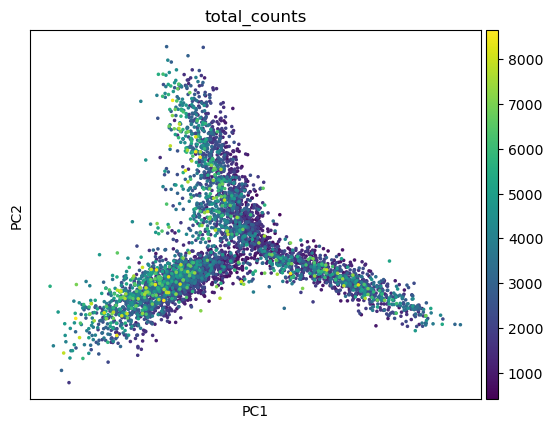

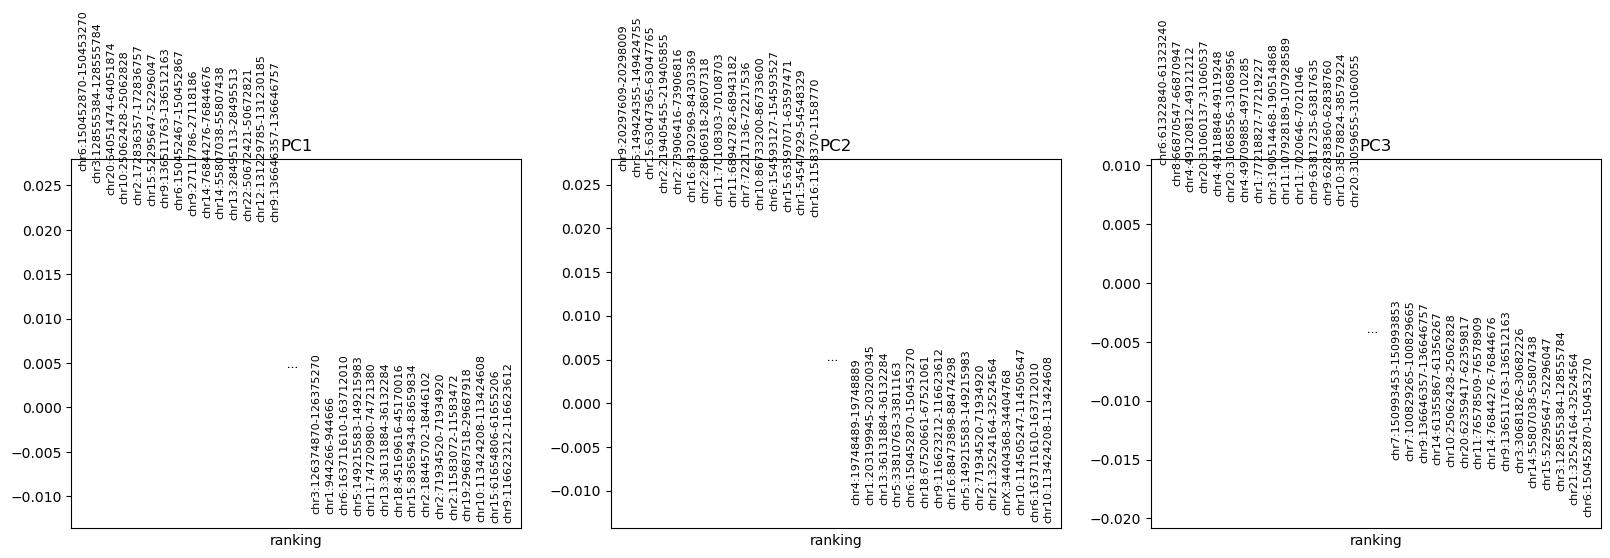

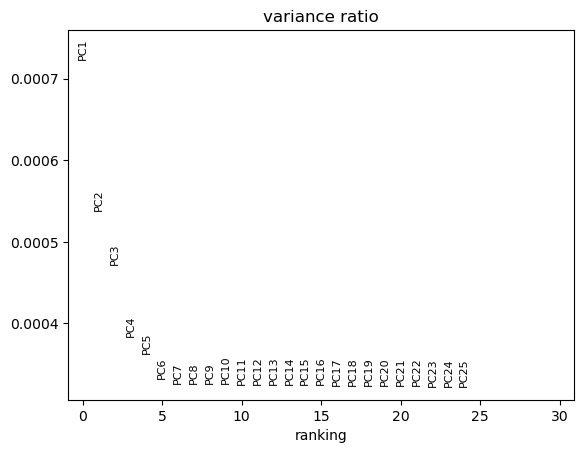

In [29]:
sc.pl.pca_overview(adata, color="total_counts")

In [30]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, method='umap', metric='euclidean')

CPU times: user 7.43 s, sys: 1.01 s, total: 8.44 s
Wall time: 7.32 s


In [31]:
%%time
sc.tl.umap(adata, min_dist=0.1, spread=2.5)

CPU times: user 9.75 s, sys: 657 ms, total: 10.4 s
Wall time: 9.58 s


<Axes: title={'center': 'log1p_n_genes_by_counts'}, xlabel='UMAP1', ylabel='UMAP2'>

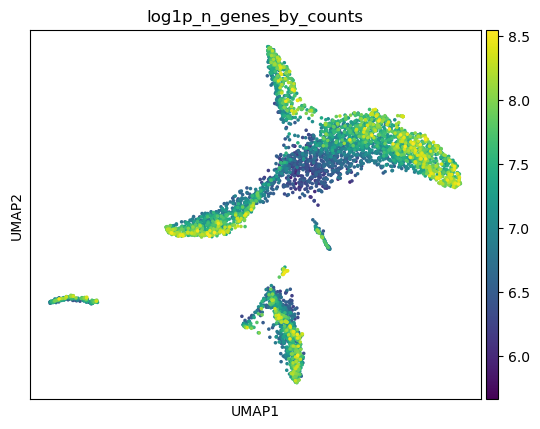

In [32]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color="log1p_n_genes_by_counts")

In [33]:
%%time
if "clusters" not in adata.uns:
    adata.uns["clusters"] = dict()

params = [
    ["lovain", 0.1],
    ["lovain", 0.25],
    ["lovain", 0.5],
    ["lovain", 1],
    ["leiden", 0.1],
    ["leiden", 0.25],
    ["leiden", 0.5],
    ["leiden", 1],
    ["kmeans", 13],
    ["kmeans", 16]
]
for method, value in params:
    tag = f'{method}_{value}'
    
    if method == 'lovain':
        sc.tl.louvain(adata, resolution=value, key_added=tag)
    elif method == 'leiden':
        sc.tl.leiden(adata, resolution=value, key_added=tag)
    elif method == 'kmeans':
        epi.tl.kmeans(adata, num_clusters=value)
        adata.obs[tag] = adata.obs["kmeans"]
        del adata.obs["kmeans"]
        adata.obs[tag] = adata.obs[tag].astype(str)
        adata.obs[tag] = adata.obs[tag].astype('category')
    else:
        print("unknown method: {method}")
    # calculate scores
    ari = epi.tl.ARI(adata, tag, 'ontology label')
    ami = epi.tl.AMI(adata, tag, 'ontology label')
    print(f"Method: {method}")
    print(f"value: {value}")
    print(f"ARI: {ari}")
    print(f"AMI: {ami}")

    
    adata.uns["clusters"][tag] = {
        "method": method,
        "param": {
           "n_clusters" if method == "kmeans" else "resolution": value 
        },
        "score": {
            "ari": ari,
            "ami": ami
        }
    }

Method: lovain
value: 0.1
ARI: 0.4954751716782306
AMI: 0.6371491512129205
Method: lovain
value: 0.25
ARI: 0.7662898047349435
AMI: 0.7693658395449955
Method: lovain
value: 0.5
ARI: 0.5796697154103297
AMI: 0.7136749839705867
Method: lovain
value: 1
ARI: 0.5432018772271628
AMI: 0.6974915741044223
Method: leiden
value: 0.1
ARI: 0.745602998529319
AMI: 0.7356543003752598
Method: leiden
value: 0.25
ARI: 0.7784557766472178
AMI: 0.7684616808764022
Method: leiden
value: 0.5
ARI: 0.6220395467070422
AMI: 0.7137719356069101
Method: leiden
value: 1
ARI: 0.41338462653253866
AMI: 0.6405001722311124


Method: kmeans
value: 13
ARI: 0.42427187948079986
AMI: 0.5775130083641281


Method: kmeans
value: 16
ARI: 0.4271047090926783
AMI: 0.5719489496512953
CPU times: user 11.3 s, sys: 5.98 s, total: 17.2 s
Wall time: 5.14 s


In [34]:
adata.uns["clusters"]

{'lovain_0.1': {'method': 'lovain',
  'param': {'resolution': 0.1},
  'score': {'ari': 0.4954751716782306, 'ami': 0.6371491512129205}},
 'lovain_0.25': {'method': 'lovain',
  'param': {'resolution': 0.25},
  'score': {'ari': 0.7662898047349435, 'ami': 0.7693658395449955}},
 'lovain_0.5': {'method': 'lovain',
  'param': {'resolution': 0.5},
  'score': {'ari': 0.5796697154103297, 'ami': 0.7136749839705867}},
 'lovain_1': {'method': 'lovain',
  'param': {'resolution': 1},
  'score': {'ari': 0.5432018772271628, 'ami': 0.6974915741044223}},
 'leiden_0.1': {'method': 'leiden',
  'param': {'resolution': 0.1},
  'score': {'ari': 0.745602998529319, 'ami': 0.7356543003752598}},
 'leiden_0.25': {'method': 'leiden',
  'param': {'resolution': 0.25},
  'score': {'ari': 0.7784557766472178, 'ami': 0.7684616808764022}},
 'leiden_0.5': {'method': 'leiden',
  'param': {'resolution': 0.5},
  'score': {'ari': 0.6220395467070422, 'ami': 0.7137719356069101}},
 'leiden_1': {'method': 'leiden',
  'param': {'re

In [35]:
# calculate best cluster:
best_tag, best_ari = None, 0
for tag in adata.uns["clusters"]:
    ari = adata.uns["clusters"][tag]["score"]["ari"]
    if ari > best_ari:
        best_tag = tag
        best_ari = ari
print(best_tag, best_ari)
adata.uns["best_cluster"] = best_tag

leiden_0.25 0.7784557766472178


<Axes: title={'center': 'leiden_0.25'}, xlabel='UMAP1', ylabel='UMAP2'>

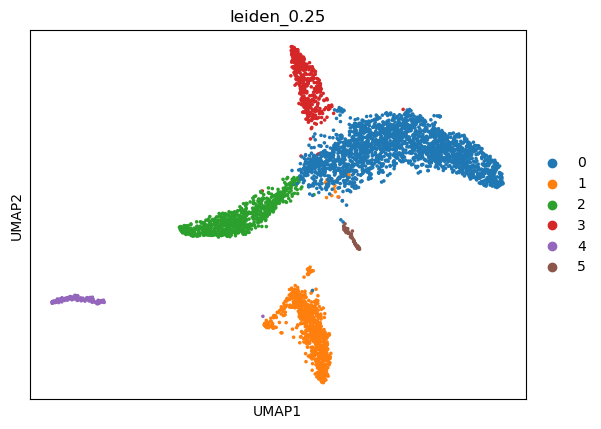

In [36]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color=adata.uns["best_cluster"])

<Axes: title={'center': 'ontology label'}, xlabel='UMAP1', ylabel='UMAP2'>

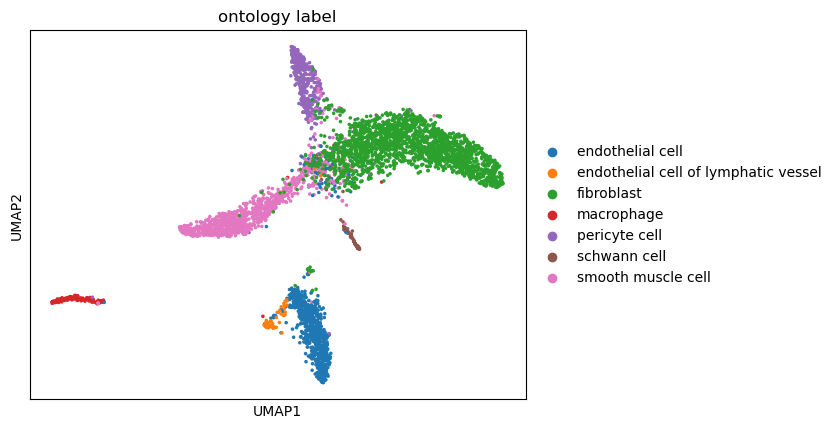

In [37]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color="ontology label")

__Rekey adata.var to genes__

In [38]:
# remove unannotated regions
adata = adata[:, ~adata.var['gene_name'].isna()]

In [39]:
duplicated_genes = adata.var['gene_name'][adata.var['gene_name'].duplicated(keep=False)]

In [40]:
%%time
adata_csc = adata.X.tocsc()

CPU times: user 124 ms, sys: 8.29 ms, total: 133 ms
Wall time: 132 ms


In [41]:
%%time
merged_data_dict = {}
for gene in duplicated_genes.unique():
    cols = np.where(adata.var['gene_name'] == gene)[0]
    data_slice = adata_csc[:, cols]
    merged = data_slice.max(axis=1)
    merged_data_dict[gene] = merged

CPU times: user 32.6 s, sys: 156 ms, total: 32.8 s
Wall time: 32.8 s


In [42]:
%%time
non_duplicated_genes = adata.var['gene_name'][~adata.var['gene_name'].duplicated(keep=False)]
for gene in non_duplicated_genes:
    cols = np.where(adata.var['gene_name'] == gene)[0]
    data_slice = adata_csc[:, cols]
    merged_data_dict[gene] = data_slice

CPU times: user 3.16 s, sys: 26.1 ms, total: 3.18 s
Wall time: 3.18 s


In [43]:
merged_matrix = hstack([l for l in merged_data_dict.values()], format='csr')

In [44]:
adata_merged = ad.AnnData(X=merged_matrix, obs=adata.obs, obsm=adata.obsm, var=pd.DataFrame(index=merged_data_dict.keys()))
adata_merged.uns.update(adata.uns)

In [45]:
%%time
adata_merged.write(
        out_file,
        compression="gzip")

CPU times: user 585 ms, sys: 3.94 ms, total: 589 ms
Wall time: 599 ms


In [46]:
adata_merged

AnnData object with n_obs × n_vars = 4554 × 50639
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell type', 'ontology label', 'ontology id', 'nb_features', 'log_nb_features', 'lovain_0.1', 'lovain_0.25', 'lovain_0.5', 'lovain_1', 'leiden_0.1', 'leiden_0.25', 'leiden_0.5', 'leiden_1', 'kmeans_13', 'kmeans_16'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'clusters', 'louvain', 'leiden', 'best_cluster', 'leiden_0.25_colors', 'ontology label_colors'
    obsm: 'X_pca', 'X_umap'

In [47]:
adata.uns["clusters"]

{'lovain_0.1': {'method': 'lovain',
  'param': {'resolution': 0.1},
  'score': {'ari': 0.4954751716782306, 'ami': 0.6371491512129205}},
 'lovain_0.25': {'method': 'lovain',
  'param': {'resolution': 0.25},
  'score': {'ari': 0.7662898047349435, 'ami': 0.7693658395449955}},
 'lovain_0.5': {'method': 'lovain',
  'param': {'resolution': 0.5},
  'score': {'ari': 0.5796697154103297, 'ami': 0.7136749839705867}},
 'lovain_1': {'method': 'lovain',
  'param': {'resolution': 1},
  'score': {'ari': 0.5432018772271628, 'ami': 0.6974915741044223}},
 'leiden_0.1': {'method': 'leiden',
  'param': {'resolution': 0.1},
  'score': {'ari': 0.745602998529319, 'ami': 0.7356543003752598}},
 'leiden_0.25': {'method': 'leiden',
  'param': {'resolution': 0.25},
  'score': {'ari': 0.7784557766472178, 'ami': 0.7684616808764022}},
 'leiden_0.5': {'method': 'leiden',
  'param': {'resolution': 0.5},
  'score': {'ari': 0.6220395467070422, 'ami': 0.7137719356069101}},
 'leiden_1': {'method': 'leiden',
  'param': {'re